In [31]:

import math
import sys
import pandas as pd
import numpy as np
from sympy import Symbol,solve
from matplotlib import pyplot as plt
import warnings
import datetime
import talib as ta
from scipy import stats
import dwj_tools.read_hdf as r
import tcoreapi_mq as t
from matplotlib import ticker
from pylab import mpl
import time
import datetime
import copy

mpl.rcParams['font.sans-serif']=['SimHei']
mpl.rcParams['axes.unicode_minus']=False
warnings.simplefilter('ignore')

core = t.TCoreZMQ(quote_port="51864", trade_port="51834")

## 最简单情形,不排除任何时间段

In [124]:
def choose_option_given_month(option, month=0):
    '''根据get_option_data得到的原始期权数据筛选给定月份的call与put的最新时刻数据
    Args:
        option: 原始期权数据
        Month: 目标月份
    Return:
        true_option_call: 带有希腊值数据的call
        true_option_put: ...
    '''
    tol = 0.1
    crt_tau = option['tau'].drop_duplicates(keep='first').tolist()[month]
    newest_index = option.index.drop_duplicates(keep='first').tolist()[-1]
    true_option = option.iloc[(option.index == newest_index).tolist()]
    true_option = true_option.iloc[list(true_option['tau'] == crt_tau)]
    true_option_call = true_option.loc[list(
        true_option['flag'] == 'C'), :].reset_index(drop=True)
    true_option_put = true_option.loc[list(
        true_option['flag'] == 'P'), :].reset_index(drop=True)
    if np.abs(true_option_call['delta']-0.5).min() > tol or np.abs(true_option_put['delta']+0.5).min() > tol:
        get_data = False
    else:
        get_data = True
    return true_option_call, true_option_put, get_data


def get_option_code(true_option_call, true_option_put):
    '''
    获取当前时刻中|delta|为0.5和-0.5的合约
    Args:
        true_option_call: 当前时刻call
        true_option_put: 当前时刻put
    Return:
        code_call_25, code_call_65, code_put_25, code_put_65
        get_data: 实值合约delta是否超出0.65给定的范围, 若超出-False, 反之-True
    '''
    tol = 0.1
    id_call_50 = np.abs(true_option_call['delta']-0.5).argmin()
    id_put_50 = np.abs(true_option_put['delta']+0.5).argmin()
    code_call_50 = true_option_call['symbol'][id_call_50]
    code_put_50 = true_option_put['symbol'][id_put_50]
    return code_call_50, code_put_50


def get_size(df, code_list, cash_vega=30000):
    '''计算各个合约手数
    Args:
        df: 期权数据
        code_list: 合约列表, 分别为call_50, put_50
    '''
    x = Symbol('x')  # call50
    y = Symbol('y')  # put50
    df_call50 = df.iloc[list(df['symbol']==code_list[0]),:]
    df_put50 = df.iloc[list(df['symbol']==code_list[1]),:]
    a = solve(
        [float(df_call50['delta'])*x+float(df_put50['delta'])*y,
         float(df_call50['vega'])*x+float(df_put50['vega'])*y-cash_vega/10000
         ],
        [x, y]
    )
    size_call50 = math.ceil(a[x])
    size_put50 = math.ceil(a[y])
    return size_call50, size_put50


def get_price_list(df, code_list):
    '''获取code_list中合约当前的价格
    '''
    price_list = []
    for csd_code in code_list:
        # print(csd_code)
        # print(df.iloc[list(df['symbol']==csd_code),:]['close'])
        price_list += [float(df.iloc[list(df['symbol']==csd_code),:]['close'])]
    return price_list


def open_position(cash, all_df, df, time_idx, flag, with_commission):
    '''开仓
    Args:
        value:  净值list
        df_50/300:  当日所有期权数据
        time_idx:  当前时刻
        flag:  多空方向
        with_commission:  是否考虑手续费
    Return:
        code_dict:  开仓合约size及开仓价格的dataframe
        value:  更新后的净值list
    '''
    csd_df = df[df.index==time_idx].reset_index(drop=True)
    csd_tau = csd_df['tau'].drop_duplicates().values[1]
    csd_df = csd_df.iloc[csd_df.index[csd_df['tau']==csd_tau],:]
    true_option_call = csd_df.loc[list(
        csd_df['flag'] == 'C'), :].reset_index(drop=True)
    true_option_put = csd_df.loc[list(
        csd_df['flag'] == 'P'), :].reset_index(drop=True)
    code_call, code_put = get_option_code(true_option_call, true_option_put)
    code_list = [code_call, code_put]
    print(code_list)
    size_call, size_put = get_size(csd_df, code_list)
    if flag=='long':
        size_list = [size_call, size_put]
    elif flag=='short':
        size_list = [-size_call, -size_put]
    else:
        sys.exit('open_position, flag有问题, 停止脚本')
    print(f'call {size_list[0]}手,put {size_list[1]}手')
    price_list = get_price_list(csd_df, code_list)
    while np.isnan(price_list[0]) or np.isnan(price_list[1]):
        print('\n'*1000+'当前收盘价有问题')
        time_idx += 1
        csd_df = all_df[all_df.index==time_idx].reset_index(drop=True)
        csd_tau = csd_df['tau'].drop_duplicates().values[1]
        csd_df = csd_df.iloc[csd_df.index[csd_df['tau']==csd_tau],:]
        price_list = get_price_list(csd_df, code_list)
    code_dict = pd.DataFrame()
    code_dict['code'] = code_list
    code_dict['close'] = price_list
    code_dict['size'] = size_list
    cash = cash - float( (code_dict['size']*code_dict['close']*10000).sum() ) - float( np.abs(code_dict['size']).sum()*2 )
    return code_dict, cash


def close_position(value, all_df, df, cash, code_dict=0, time_idx=0, with_commission=1, jump_tag=False):
    '''平仓或计算净值
    Args:
        jump_tag: 日内有交易则jumptag=True, 用以判断是否加入手续费
    Return:
        value:
        cash:
    '''
    value_copy = copy.deepcopy(value)
    csd_df = df[df.index==time_idx].reset_index(drop=True)
    if not jump_tag:
        csd_df = df[df.index==235].reset_index(drop=True)
    price_list = get_price_list(csd_df, list(code_dict['code']))
    temp_code_dict = code_dict.copy(deep=True)
    temp_code_dict['crt_close'] = price_list
    print('当前收盘价')
    while np.isnan(price_list[0]) or np.isnan(price_list[1]):
        print('\n'*1000+'当前收盘价有问题')
        time_idx += 1
        csd_df = all_df[all_df.index==time_idx].reset_index(drop=True)
        price_list = get_price_list(csd_df, list(code_dict['code']))
        temp_code_dict['crt_close'] = price_list
    print(np.array(price_list))
    print('上次收盘价')
    print(np.array(temp_code_dict['close'].values))
    # cash = cash + float( (np.array(list(temp_code_dict['size'].values))*(np.array(list(temp_code_dict['crt_close'].values))-np.array(list(temp_code_dict['close'].values)))*10000).sum() )
    cash = cash + float( (np.array(list(temp_code_dict['size'].values))*(np.array(list(temp_code_dict['crt_close'].values)))*10000).sum() )
    if jump_tag:
        cash = cash  - float( np.abs(temp_code_dict['size']).sum()*2 ) * with_commission
    value_copy += [cash]
    temp_code_dict['close'] = temp_code_dict['crt_close']
    # print(temp_code_dict)
    return value_copy, cash, temp_code_dict


def bt_garch_vanilla(pred_list, start_date, end_date, csd_range):
    '''garch预测回测
    Args:
    
    Return:
    
    '''
    cash = 10000000
    value = [cash]
    having_position = False
    flag = 0
    tradingday = pd.read_excel('tradingday.xlsx',index_col=0)
    date_list = [i.strftime('%Y%m%d') for i in tradingday.index]
    start_idx = date_list.index(start_date)
    end_idx = date_list.index(end_date)
    csd_time_horizon = date_list[start_idx:end_idx]
    firmed_csd_range = [i*15 for i in range(16)] + [235]
    csd_range = [i*15 for i in csd_range]
    drop_id = 0
    adj_id = 0
    for i, crt_date in enumerate(csd_time_horizon):
        forced_close = False
        print(f'\n\n\n\n当前日期{crt_date}')
        if crt_date[:4]!=globals()['date_pred'][(i-adj_id)*18][:4] or crt_date[4:6]!=globals()['date_pred'][(i-adj_id)*18][5:7] or crt_date[6:]!=globals()['date_pred'][(i-adj_id)*18][8:10]:
            print('日期错误'+'\n'*2000)
            drop_id = i
            adj_id += 1
            continue
        all_df, _, _ = r.read_data_dogsk('510300', str(crt_date))
        df, _, _ = r.read_data_dogsk('510300', str(crt_date), firmed_csd_range)
        crt_tau = df['tau'].drop_duplicates(keep='first').tolist()[0]
        if crt_tau==0:  # 强制平仓
            print(f'到期日,强制平仓')
            if flag!=0:
                forced_close = True
            else:
                value += [value[-1]]
                print(f'今日value:{value[-1]}')
                continue
        csd_pred = pred_list[(i-adj_id)*18:(i-adj_id)*18+18]  # 当前的pred
        csd_datetime = globals()['date_pred'][(i-adj_id)*18:(i-adj_id)*18+18]
        csd_datetime = csd_datetime[:8]+csd_datetime[9:-1]
        csd_pred = csd_pred[:8]+csd_pred[9:-1]  # 当天去掉午休和隔夜后剩余的pred
        print(f'今日日期为{csd_datetime}')
        print(f'今日pred为{csd_pred}')
        for j, crt_range in enumerate(csd_range):
            if forced_close:
                flag = 0
                value, cash, _ = close_position(value, all_df, df, cash, code_dict, crt_range, 1, jump_tag=True)
                print(f'\n今日强制平仓,value:{value[-1]}')
                break
            temp_pred = csd_pred[j]
            print(f'\n当前分钟:{crt_range}, 当前pred:{temp_pred:.2f}, 当前仓位:{flag}')
            if (temp_pred>0 and flag=='long') or (temp_pred<0 and flag=='short') or (temp_pred==0 and flag==0):  # 判断仓位不变
                print('判断不改变仓位')
                continue
            elif flag==0 and temp_pred!=0:  # 判断开仓
                if temp_pred>0:
                    flag = 'long'
                else:
                    flag = 'short'
                code_dict, cash = open_position(cash, all_df, df, crt_range, flag, 1)
                print(f'判断开{flag}仓, 开仓后cash变为{cash}')
                print(code_dict)
            else:  # 有平仓操作
                # 先平仓
                _, cash, _ = close_position(value, all_df, df, cash, code_dict, crt_range, 1, jump_tag=True)
                print(f'平仓, 平仓后cash变为{cash}')
                if (flag=='long' and temp_pred<0) or (flag=='short' and temp_pred>0):  # 判断开仓
                    if flag=='long':
                        flag = 'short'
                    else:
                        flag = 'long'
                    code_dict, cash = open_position(cash, all_df, df, crt_range, flag, 1)
                    print(f'进一步判断开{flag}仓, 开仓后cash变为{cash}')
                    print(code_dict)
                else:
                    flag = 0
        if not forced_close:
            if flag!=0:
                value, _, _ = close_position(value, all_df, df, cash, code_dict, crt_range, 1, jump_tag=False)
            else:
                value += [cash]
            print(f'今日value:{value[-1]}')
    date = csd_time_horizon[:drop_id]+csd_time_horizon[drop_id+1:]
    data = value[1:]
    index_j = np.argmax(np.maximum.accumulate(data) - data)  # 结束位置
    index_i = np.argmax(data[:index_j])  # 开始位置
    d = data[index_j]/data[index_i]-1  # 最大回撤
    print(len(date))
    print(len(data))
    print(index_i)
    print(index_j)
    print(
        f'最大回撤开始时间为{date[index_i]},结束时间为{date[index_j]},\n最大回撤为{d*100:.2f}%,')
    rtn = pd.DataFrame()
    rtn['close'] = data
    rtn.index = date
    daily_rtn = rtn['close'].pct_change()
    daily_rtn.dropna(inplace=True)
    sharp = daily_rtn.mean()/daily_rtn.std()*np.sqrt(245)
    annual_return = (value[-1]/10000000 - 1)/len(date) * 245
    print(f'年化{annual_return*100:.1f}%')
    return value, date, d, annual_return, sharp


In [119]:
pred = pd.read_csv('train_preds_mir.csv',index_col=0)
globals()['date_pred'] = list(pred.iloc[361:-17,:].reset_index(drop=True)['datetime'])
pred = list(pred.iloc[361:-17,:].reset_index(drop=True)['hybrid'])


value, date, d, annual_return, sharp = bt_garch_vanilla(pred, '20200306', '20220708', [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15])





当前日期20200306
今日日期为['2020-03-06 09:45:00', '2020-03-06 10:00:00', '2020-03-06 10:15:00', '2020-03-06 10:30:00', '2020-03-06 10:45:00', '2020-03-06 11:00:00', '2020-03-06 11:15:00', '2020-03-06 11:30:00', '2020-03-06 13:15:00', '2020-03-06 13:30:00', '2020-03-06 13:45:00', '2020-03-06 14:00:00', '2020-03-06 14:15:00', '2020-03-06 14:30:00', '2020-03-06 14:45:00', '2020-03-06 15:00:00']
今日pred为[0.0231162912410578, -0.0300009273825881, 0.0049404550452779705, 0.0200279365609571, -0.0137538763267126, -0.0131056781934106, -0.00329895770158659, -0.00307565438269334, -0.0279810230787527, -0.030890692237929, -0.0232179128486976, 0.0427136351393155, -0.0066105749536434, -0.009187343141278491, -0.0265648162639658, 0.0230301628468794]

当前分钟:0, 当前pred:0.02, 当前仓位:0
['TC.O.SSE.510050.202004.C.3', 'TC.O.SSE.510050.202004.P.3']
call 339手,put 344手
判断开long仓, 开仓后cash变为9393012.0
                         code   close size
0  TC.O.SSE.510050.202004.C.3  0.0858  339
1  TC.O.SSE.510050.202004.P.3  0.0915  3

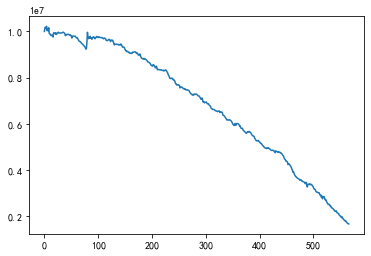

In [122]:
plt.plot(value[1:])

## 加入各种限制条件

- 去除10:00和14:15两个时间点的预测值
- 去除diff_atm_imvol和pred同正或者同负的情形
- 仅保留20分位数以上和70分位数以下iv时的预测值
- 仅保留40分位数以上和60分位数以下pred时的预测值
- diff_atm_imvol连续四次同向变化下的预测值

In [32]:
def choose_option_given_month(option, month=0):
    '''根据get_option_data得到的原始期权数据筛选给定月份的call与put的最新时刻数据
    Args:
        option: 原始期权数据
        Month: 目标月份
    Return:
        true_option_call: 带有希腊值数据的call
        true_option_put: ...
    '''
    tol = 0.1
    crt_tau = option['tau'].drop_duplicates(keep='first').tolist()[month]
    newest_index = option.index.drop_duplicates(keep='first').tolist()[-1]
    true_option = option.iloc[(option.index == newest_index).tolist()]
    true_option = true_option.iloc[list(true_option['tau'] == crt_tau)]
    true_option_call = true_option.loc[list(
        true_option['flag'] == 'C'), :].reset_index(drop=True)
    true_option_put = true_option.loc[list(
        true_option['flag'] == 'P'), :].reset_index(drop=True)
    if np.abs(true_option_call['delta']-0.5).min() > tol or np.abs(true_option_put['delta']+0.5).min() > tol:
        get_data = False
    else:
        get_data = True
    return true_option_call, true_option_put, get_data


def get_option_code(true_option_call, true_option_put):
    '''
    获取当前时刻中|delta|为0.5和-0.5的合约
    Args:
        true_option_call: 当前时刻call
        true_option_put: 当前时刻put
    Return:
        code_call_25, code_call_65, code_put_25, code_put_65
        get_data: 实值合约delta是否超出0.65给定的范围, 若超出-False, 反之-True
    '''
    tol = 0.1
    id_call_50 = np.abs(true_option_call['delta']-0.5).argmin()
    id_put_50 = np.abs(true_option_put['delta']+0.5).argmin()
    code_call_50 = true_option_call['symbol'][id_call_50]
    code_put_50 = true_option_put['symbol'][id_put_50]
    return code_call_50, code_put_50


def get_size(df, code_list, cash_vega=30000):
    '''计算各个合约手数
    Args:
        df: 期权数据
        code_list: 合约列表, 分别为call_50, put_50
    '''
    x = Symbol('x')  # call50
    y = Symbol('y')  # put50
    df_call50 = df.iloc[list(df['symbol'] == code_list[0]), :]
    df_put50 = df.iloc[list(df['symbol'] == code_list[1]), :]
    a = solve(
        [float(df_call50['delta'])*x+float(df_put50['delta'])*y,
         float(df_call50['vega'])*x+float(df_put50['vega'])*y-cash_vega/10000
         ],
        [x, y]
    )
    size_call50 = math.ceil(a[x])
    size_put50 = math.ceil(a[y])
    return size_call50, size_put50


def get_price_list(df, code_list):
    '''获取code_list中合约当前的价格
    '''
    price_list = []
    for csd_code in code_list:
        # print(csd_code)
        # print(df.iloc[list(df['symbol']==csd_code),:]['close'])
        price_list += [float(df.iloc[list(df['symbol']
                                          == csd_code), :]['close'])]
    return price_list


def open_position(cash, all_df, df, time_idx, flag, with_commission):
    '''开仓
    Args:
        value:  净值list
        df_50/300:  当日所有期权数据
        time_idx:  当前时刻
        flag:  多空方向
        with_commission:  是否考虑手续费
    Return:
        code_dict:  开仓合约size及开仓价格的dataframe
        value:  更新后的净值list
    '''
    csd_df = df[df.index == time_idx].reset_index(drop=True)
    csd_tau = csd_df['tau'].drop_duplicates().values[1]
    csd_df = csd_df.iloc[csd_df.index[csd_df['tau'] == csd_tau], :]
    true_option_call = csd_df.loc[list(
        csd_df['flag'] == 'C'), :].reset_index(drop=True)
    true_option_put = csd_df.loc[list(
        csd_df['flag'] == 'P'), :].reset_index(drop=True)
    code_call, code_put = get_option_code(true_option_call, true_option_put)
    code_list = [code_call, code_put]
    print(code_list)
    size_call, size_put = get_size(csd_df, code_list)
    if flag == 'long':
        size_list = [size_call, size_put]
    elif flag == 'short':
        size_list = [-size_call, -size_put]
    else:
        sys.exit('open_position, flag有问题, 停止脚本')
    print(f'call {size_list[0]}手,put {size_list[1]}手')
    price_list = get_price_list(csd_df, code_list)
    while np.isnan(price_list[0]) or np.isnan(price_list[1]):
        print('\n'*1000+'当前收盘价有问题')
        time_idx += 1
        csd_df = all_df[all_df.index == time_idx].reset_index(drop=True)
        csd_tau = csd_df['tau'].drop_duplicates().values[1]
        csd_df = csd_df.iloc[csd_df.index[csd_df['tau'] == csd_tau], :]
        price_list = get_price_list(csd_df, code_list)
    code_dict = pd.DataFrame()
    code_dict['code'] = code_list
    code_dict['close'] = price_list
    code_dict['size'] = size_list
    cash = cash - float((code_dict['size']*code_dict['close']
                         * 10000).sum()) - float(np.abs(code_dict['size']).sum()*2)
    return code_dict, cash


def close_position(value, all_df, df, cash, code_dict=0, time_idx=0, with_commission=1, jump_tag=False):
    '''平仓或计算净值
    Args:
        jump_tag: 日内有交易则jumptag=True, 用以判断是否加入手续费
    Return:
        value:
        cash:
    '''
    value_copy = copy.deepcopy(value)
    csd_df = df[df.index == time_idx].reset_index(drop=True)
    if not jump_tag:
        csd_df = df[df.index == 235].reset_index(drop=True)
    price_list = get_price_list(csd_df, list(code_dict['code']))
    temp_code_dict = code_dict.copy(deep=True)
    temp_code_dict['crt_close'] = price_list
    print('当前收盘价')
    while np.isnan(price_list[0]) or np.isnan(price_list[1]):
        print('\n'*1000+'当前收盘价有问题')
        time_idx += 1
        csd_df = all_df[all_df.index == time_idx].reset_index(drop=True)
        price_list = get_price_list(csd_df, list(code_dict['code']))
        temp_code_dict['crt_close'] = price_list
    print(np.array(price_list))
    print('上次收盘价')
    print(np.array(temp_code_dict['close'].values))
    # cash = cash + float( (np.array(list(temp_code_dict['size'].values))*(np.array(list(temp_code_dict['crt_close'].values))-np.array(list(temp_code_dict['close'].values)))*10000).sum() )
    cash = cash + float((np.array(list(temp_code_dict['size'].values))*(
        np.array(list(temp_code_dict['crt_close'].values)))*10000).sum())
    if jump_tag:
        cash = cash - \
            float(np.abs(temp_code_dict['size']).sum()*2) * with_commission
    value_copy += [cash]
    temp_code_dict['close'] = temp_code_dict['crt_close']
    # print(temp_code_dict)
    return value_copy, cash, temp_code_dict


def bt_garch_with_restri(pred_list, start_date, end_date, csd_range):
    '''garch预测回测
    Args:

    Return:

    '''
    cash = 10000000
    value = [cash]
    having_position = False
    flag = 0
    tradingday = pd.read_excel('tradingday.xlsx', index_col=0)
    date_list = [i.strftime('%Y%m%d') for i in tradingday.index]
    start_idx = date_list.index(start_date)
    end_idx = date_list.index(end_date)
    csd_time_horizon = date_list[start_idx:end_idx]
    firmed_csd_range = [i*15 for i in range(16)] + [235]
    firmed_csd_range = [5]+firmed_csd_range[1:]
    csd_range = [i*15 for i in csd_range]
    csd_range = [5] + csd_range[1:]
    drop_id = 0
    adj_id = 0
    count = 0
    for i, crt_date in enumerate(csd_time_horizon):
        forced_close = False
        print(f'\n\n\n\n当前日期{crt_date}')
        if crt_date[:4] != globals()['date_pred'][(i-adj_id)*18][:4] or crt_date[4:6] != globals()['date_pred'][(i-adj_id)*18][5:7] or crt_date[6:] != globals()['date_pred'][(i-adj_id)*18][8:10]:
            print('日期错误'+'\n'*2000)
            drop_id = i
            adj_id += 1
            continue
        all_df, _, _ = r.read_data_dogsk('510300', str(crt_date))
        df, _, _ = r.read_data_dogsk('510300', str(crt_date), firmed_csd_range)
        crt_tau = df['tau'].drop_duplicates(keep='first').tolist()[0]
        if crt_tau == 0:  # 强制平仓
            print(f'到期日,强制平仓')
            if flag != 0:
                forced_close = True
            else:
                value += [value[-1]]
                print(f'今日value:{value[-1]}')
                continue

        crt_day_all_pred = pred_list[(i-adj_id)*18:(i-adj_id)*18+18]  # 当前的pred
        csd_datetime = globals()['date_pred'][(i-adj_id)*18:(i-adj_id)*18+18]
        csd_datetime = csd_datetime[:8]+csd_datetime[9:-1]
        csd_pred = crt_day_all_pred[:8] + crt_day_all_pred[9:-1]  # 当天去掉午休和隔夜后剩余的pred
        diff_atm_imvol = globals()['diff_iv'][360 +
                                              (i-adj_id)*18-3:360+(i-adj_id)*18+18]
        atm_imvol = globals()['atm_iv'][(i-adj_id)*18:(i-adj_id)*18+18]
        atm_imvol = atm_imvol[:8] + atm_imvol[9:-1]
        lrtn = globals()['adj_lrtn'][(i-adj_id)*18:(i-adj_id)*18+18]
        lrtn = lrtn[:8] + lrtn[9:-1]
        print(f'今日日期为{csd_datetime}')
        print(f'今日pred为{csd_pred}')
        for j, crt_range in enumerate(csd_range):
            if crt_range==5:
                j = 0
            else:
                j = int(crt_range/15)
            if forced_close:
                flag = 0
                value, cash, _ = close_position(
                    value, all_df, df, cash, code_dict, crt_range, 1, jump_tag=True)
                print(f'\n今日强制平仓,value:{value[-1]}')
                break
            temp_time = csd_datetime[j]
            temp_pred = csd_pred[j]
            temp_idx = crt_day_all_pred.index(temp_pred)
            temp_iv = atm_imvol[j]
            temp_lrtn = lrtn[j]
            temp_diff_iv = diff_atm_imvol[3+temp_idx]
            diff_iv_hist = diff_atm_imvol[temp_idx:temp_idx+4]
            print(f'\n当前分钟:{crt_range}, 当前时间:{temp_time}, 当前pred:{temp_pred:.4f}, 当前adj_lrtn:{temp_lrtn:.5f}, 当前atm_iv:{temp_iv:.3f}, 当前diff_iv:{temp_diff_iv:.4f}, 当前四次diff_iv:{diff_iv_hist}, 当前仓位:{flag}')
            if temp_diff_iv*temp_pred>0:
                print(f'当前pred和diff_iv同向, 跳过')
                continue
            if temp_diff_iv*temp_lrtn>0:
                print(f'当前lrtn和diff_iv同向, 跳过')
                continue
            thres1=0.169159503877789
            thres2=0.214962695219699
            if thres2>temp_iv>thres1:
                print('当前iv超出阈值, 跳过')
                continue
            if (diff_iv_hist[0]>0 and diff_iv_hist[1]>0 and diff_iv_hist[2]>0 and diff_iv_hist[3]>0 and temp_pred<0) or (diff_iv_hist[0]<0 and diff_iv_hist[1]<0 and diff_iv_hist[2]<0 and diff_iv_hist[3]<0 and temp_pred>0):
                print('趋势性行情给出相反预测, 跳过')
                continue
            thres1=0.0177917333761545
            thres2=0.0402821283716937
            # if thres2>np.abs(temp_pred)>thres1:
            if thres2>temp_pred>thres1:
                print('当前pred绝对值超出阈值, 跳过')
                continue
            if (temp_pred > 0 and flag == 'long') or (temp_pred < 0 and flag == 'short') or (temp_pred == 0 and flag == 0):  # 判断仓位不变
                print('判断不改变仓位')
                continue
            elif flag == 0 and temp_pred != 0:  # 判断开仓
                if temp_pred > 0:
                    flag = 'long'
                else:
                    flag = 'short'
                code_dict, cash = open_position(
                    cash, all_df, df, crt_range, flag, 1)
                count += 1
                print(f'判断开{flag}仓, 开仓后cash变为{cash}')
                print(code_dict)
            else:  # 有平仓操作
                # 先平仓
                _, cash, _ = close_position(
                    value, all_df, df, cash, code_dict, crt_range, 1, jump_tag=True)
                print(f'平仓, 平仓后cash变为{cash}')
                if (flag == 'long' and temp_pred < 0) or (flag == 'short' and temp_pred > 0):  # 判断开仓
                    if flag == 'long':
                        flag = 'short'
                    else:
                        flag = 'long'
                    code_dict, cash = open_position(
                        cash, all_df, df, crt_range, flag, 1)
                    count += 1
                    print(f'进一步判断开{flag}仓, 开仓后cash变为{cash}')
                    print(code_dict)
                else:
                    flag = 0
        if not forced_close:
            if flag != 0:
                value, _, _ = close_position(
                    value, all_df, df, cash, code_dict, crt_range, 1, jump_tag=False)
            else:
                value += [cash]
            print(f'今日value:{value[-1]}')
    date = csd_time_horizon[:drop_id]+csd_time_horizon[drop_id+1:]
    data = value[1:]
    index_j = np.argmax(np.maximum.accumulate(data) - data)  # 结束位置
    index_i = np.argmax(data[:index_j])  # 开始位置
    d = data[index_j]/data[index_i]-1  # 最大回撤
    print(len(date))
    print(len(data))
    print(index_i)
    print(index_j)
    print(
        f'最大回撤开始时间为{date[index_i]},结束时间为{date[index_j]},\n最大回撤为{d*100:.2f}%,')
    rtn = pd.DataFrame()
    rtn['close'] = data
    rtn.index = date
    daily_rtn = rtn['close'].pct_change()
    daily_rtn.dropna(inplace=True)
    sharp = daily_rtn.mean()/daily_rtn.std()*np.sqrt(245)
    annual_return = (value[-1]/10000000 - 1)/len(date) * 245
    print(f'年化{annual_return*100:.1f}%')
    return value, date, d, annual_return, sharp, count


In [33]:
globals()['all_pred'] = pd.read_csv('train_preds_mir.csv',index_col=0)
globals()['date_pred'] = list(all_pred.iloc[361:-17,:].reset_index(drop=True)['datetime'])
pred = list(all_pred.iloc[361:-17,:].reset_index(drop=True)['hybrid'])
globals()['atm_iv'] = list(all_pred.iloc[360:-18,:].reset_index(drop=True)['atm_imVol'])
globals()['diff_iv'] = list(all_pred.iloc[:-17,:].reset_index(drop=True)['diff_atm_imVol'])
globals()['adj_lrtn'] = list(all_pred.iloc[360:-18,:].reset_index(drop=True)['adj_lrtn'])

value, date, d, annual_return, sharp, count = bt_garch_with_restri(pred, '20200306', '20220708', [0,1,3,4,5,7,9,10,12,14,15])





当前日期20200306
今日日期为['2020-03-06 09:45:00', '2020-03-06 10:00:00', '2020-03-06 10:15:00', '2020-03-06 10:30:00', '2020-03-06 10:45:00', '2020-03-06 11:00:00', '2020-03-06 11:15:00', '2020-03-06 11:30:00', '2020-03-06 13:15:00', '2020-03-06 13:30:00', '2020-03-06 13:45:00', '2020-03-06 14:00:00', '2020-03-06 14:15:00', '2020-03-06 14:30:00', '2020-03-06 14:45:00', '2020-03-06 15:00:00']
今日pred为[0.0231162912410578, -0.0300009273825881, 0.0049404550452779705, 0.0200279365609571, -0.0137538763267126, -0.0131056781934106, -0.00329895770158659, -0.00307565438269334, -0.0279810230787527, -0.030890692237929, -0.0232179128486976, 0.0427136351393155, -0.0066105749536434, -0.009187343141278491, -0.0265648162639658, 0.0230301628468794]

当前分钟:5, 当前时间:2020-03-06 09:45:00, 当前pred:0.0231, 当前adj_lrtn:-0.00341, 当前atm_iv:0.222, 当前diff_iv:0.0003, 当前四次diff_iv:[5.36091396433902e-05, 0.00014405217425828002, 0.00183416503510475, 0.000308915674101712], 当前仓位:0
当前pred和diff_iv同向, 跳过

当前分钟:15, 当前时间:2020-03-06 10

(array([ 9500000., 10000000., 10500000., 11000000., 11500000., 12000000.,
        12500000., 13000000., 13500000.]),
 <a list of 9 Text major ticklabel objects>)

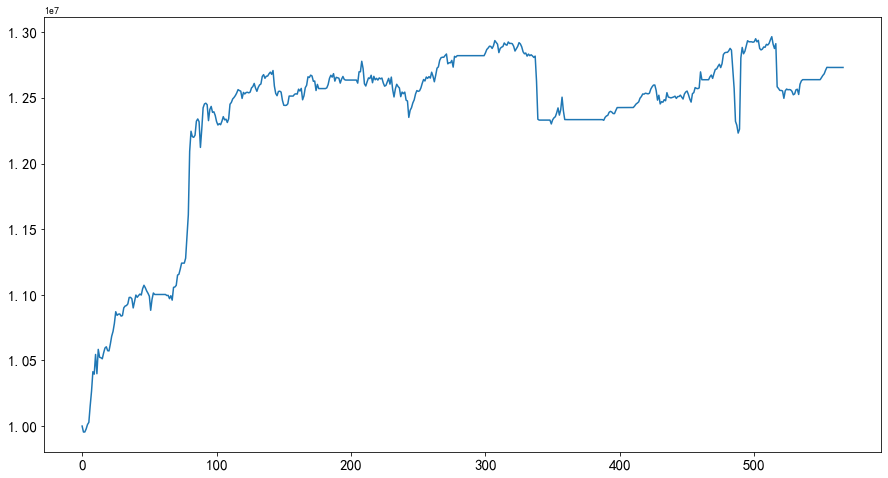

In [34]:
fig = plt.figure(figsize=(15,8))
plt.plot(value[1:])
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

In [35]:
value[-1]

12732661.0